In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob, os, random
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from scipy.signal import savgol_filter
from scipy import interpolate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
np.random.seed( 0 )
sns.set_style( "darkgrid" )

## Preprocessing/Cleaning

In [3]:
df = pd.read_parquet("/home/lselig/selig-fa/finance/.data/ratios.parquet")
df["year"] = pd.DatetimeIndex(df["date"]).year
# df = df[df.year >= 2019]
print(df.shape)
print(df.describe())
print(list(df))
print(df.isna().sum())

# lots of missing values, these columns are missing most frequently (> 100k / 350k)
worst_offenders = ["totalDebtToCapitalization", "interestCoverage", "inventoryTurnover", "cashFlowCoverageRatios", "shortTermCoverageRatios",
                   "dividendPaidAndCapexCoverageRatio", "dividendPayoutRatio", "dividendYield"]

df.drop(columns = worst_offenders, inplace = True)
print(df.shape)

df.dropna(inplace = True)
print(df.shape)


qualitative_cols = ["symbol", "date", "period", "year"]
qualitatives = df[qualitative_cols]
df.drop(columns = qualitative_cols, inplace = True)
print(df.shape)


(320932, 58)
       currentRatio    quickRatio     cashRatio  daysOfSalesOutstanding  \
count  2.976720e+05  2.976720e+05  2.976720e+05            3.019540e+05   
mean  -5.017057e+03  2.349109e+02  4.160446e+01            1.849241e+11   
std    2.255308e+06  7.523414e+04  1.215209e+04            9.063255e+13   
min   -1.189378e+09 -1.612800e+04 -8.273333e+02           -7.199407e+08   
25%    1.110439e+00  6.632349e-01  1.163417e-01            1.098284e+02   
50%    1.902921e+00  1.228571e+00  4.082687e-01            1.988432e+02   
75%    3.556716e+00  2.530507e+00  1.207422e+00            2.895755e+02   
max    7.914931e+05  4.032705e+07  6.124554e+06            4.964380e+16   

       daysOfInventoryOutstanding  operatingCycle  daysOfPayablesOutstanding  \
count                2.367580e+05    2.354650e+05               2.367580e+05   
mean                 6.699223e+10    7.282423e+10               2.321350e+10   
std                  3.259131e+13    3.315801e+13               7.98709

In [9]:
features = df.to_numpy()
# features = df
scaler = StandardScaler()
features =  scaler.fit_transform(features)
features = np.clip(features, -5, 5)
print(features.shape)
n_features = features.shape[1]
print(n_features)
%matplotlib widget 
for i in range(n_features):
    print(i, np.nanmin(features[:, i]), np.nanmax(features[:, i]))
    sns.kdeplot(features[:, i])
plt.title("Distribution of final features")
plt.close()

(153672, 46)
46
0 -0.18356885604035567 5.0
1 -0.0664509871933792 5.0
2 -0.00836746992286299 5.0
3 -0.0035767889864144003 5.0
4 -0.002551344971648874 5.0
5 -0.0025760473391453634 5.0
6 -0.002599013586340187 5.0
7 -0.32869540911434936 5.0
8 -5.0 0.08605207548814277
9 -5.0 0.0025562402420052583
10 -5.0 0.002556175446448017
11 -5.0 0.002555126411454813
12 -5.0 2.6357996275395563
13 -5.0 5.0
14 -5.0 5.0
15 -5.0 5.0
16 -2.3761888043148702 5.0
17 -5.0 5.0
18 -5.0 0.002556240242011862
19 -2.206727751372277 5.0
20 -5.0 5.0
21 -5.0 5.0
22 -5.0 5.0
23 -5.0 5.0
24 -0.07812780456454373 5.0
25 -0.9896469391857822 5.0
26 -0.1264837810512427 5.0
27 -0.23186366168486097 5.0
28 -5.0 5.0
29 -5.0 5.0
30 -0.00264728642330038 5.0
31 -5.0 5.0
32 -5.0 0.002558503041013093
33 -5.0 5.0
34 -5.0 5.0
35 -5.0 5.0
36 -5.0 5.0
37 -0.002552894681865704 5.0
38 -5.0 5.0
39 -5.0 5.0
40 -5.0 5.0
41 -5.0 5.0
42 -0.013417510903483174 5.0
43 -0.002552894681865704 5.0
44 -5.0 0.0025570105308068193
45 -5.0 5.0


                                    currentRatio  quickRatio     cashRatio  \
currentRatio                        1.000000e+00   -0.000011 -1.075434e-05   
quickRatio                         -1.104824e-05    1.000000  7.421048e-01   
cashRatio                          -1.075434e-05    0.742105  1.000000e+00   
daysOfSalesOutstanding              4.650894e-05    0.000009  6.009565e-06   
daysOfInventoryOutstanding          9.796549e-06   -0.000002  5.338826e-06   
operatingCycle                      1.041607e-05   -0.000002  5.366906e-06   
daysOfPayablesOutstanding           1.084083e-05   -0.000002  5.406601e-06   
cashConversionCycle                 1.031359e-05   -0.000002  5.357302e-06   
grossProfitMargin                   1.677342e-05    0.000011  7.183863e-06   
operatingProfitMargin              -9.923959e-06    0.000002 -5.343952e-06   
pretaxProfitMargin                 -9.922877e-06    0.000002 -5.343831e-06   
netProfitMargin                    -9.896632e-06    0.000002 -5.

<AxesSubplot:>

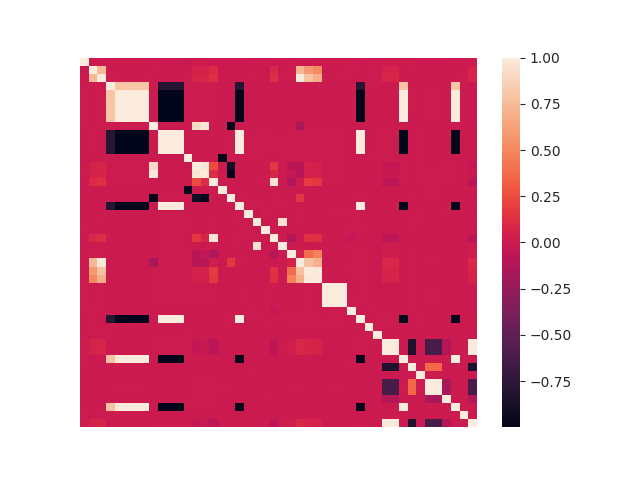

In [6]:
corr = df.corr()
print(corr)
sns.heatmap(corr, annot = False, xticklabels= False, yticklabels=False)


In [7]:
print(features.shape)
pca = PCA(n_components=2)
pca.fit(features.T)
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))
components = pca.components_.T
print(components.shape)
# plt.close()
# plt.hist2d(components[:, 0], components[:, 1], bins = 100)
# plt.show()

(153672, 46)
[0.77760201 0.11257187]
0.8901738835034827
(153672, 2)


# Goal: Use clustering to identify potential outliers based on financial ratios

[91448 91449 91450]
[148357 148358 148359 148360 148361 148362 148363 148364 148365 148366
 148367 148368 148369 148370 148371 148372 148373 148374 148375 148376
 148377 148378 148379 148380 148381 148382 148383 148384 148385 148386
 148387 148388 148389 148390 148391 148392 148393 148394 148395 148396
 148397 148398 148399 148400 148401 148402 148403 148404 148405 148406
 148407 148408 148409 148410 148411 148412 148413 148414 148415 148416
 148417 148418]
[136084 136085 136086]
(153672, 3)


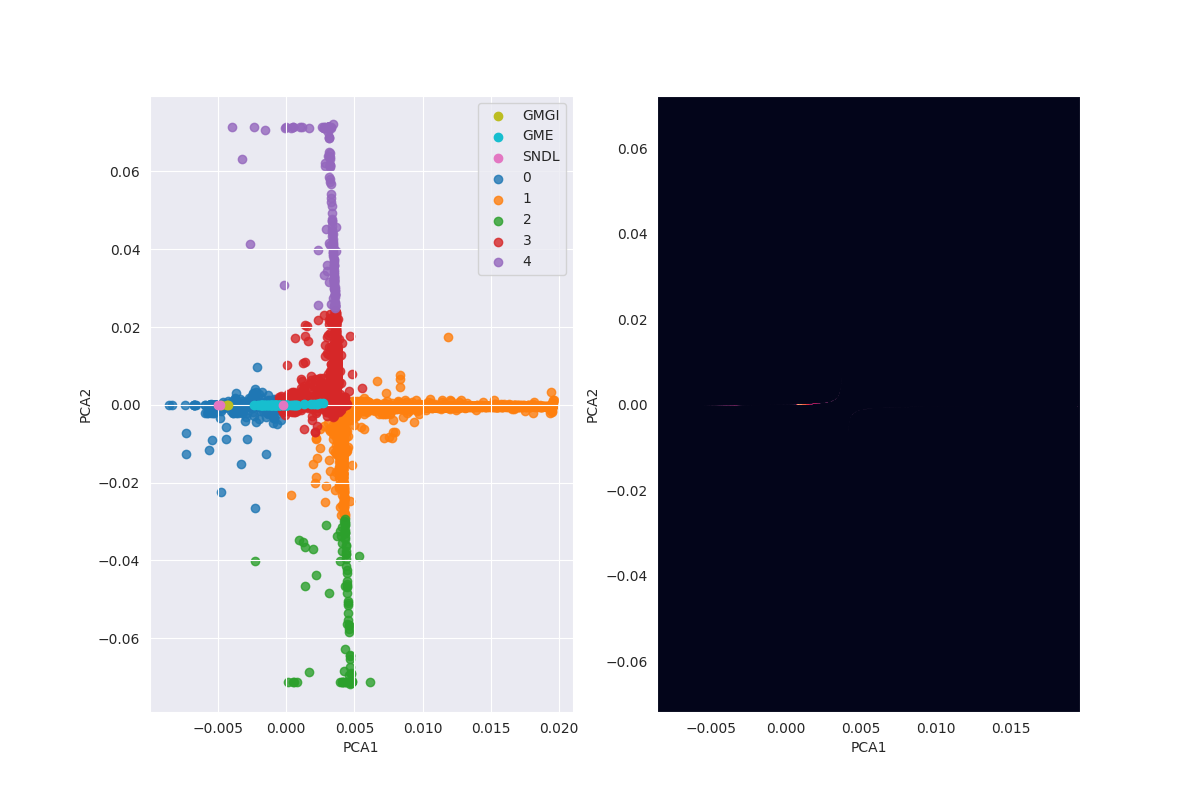

In [8]:
from sklearn.cluster import KMeans, DBSCAN
# from sklearn.cluster import AffinityPropagation

# winners = ["AAPL", "MSFT", "GOOGL"]

clst = KMeans(n_clusters=5, random_state=0).fit(components)
# clst = DBSCAN(eps = 0.0001, min_samples = 10).fit(components)
# clst = AffinityPropagation( random_state=0).fit(components)
labels = clst.labels_.reshape(-1, 1)
# print(qualitatives)
tickers = qualitatives.symbol.values
fig, axs = plt.subplots(1, 2, figsize = (12, 8))
pca_and_labels = np.hstack((components, labels))

def overlay_specific_stock(ticker, ax, color = "C8", show_date = False):
    winners_idx = np.where(tickers == ticker)[0]
    print(winners_idx)
    x = pca_and_labels[winners_idx][:, 0]
    y = pca_and_labels[winners_idx][:, 1]
    ax.scatter(x, y, label = ticker, color = color, zorder = 1)
    if(show_date):
        for idx in winners_idx:
            x = pca_and_labels[idx][0]
            y = pca_and_labels[idx][1]
            ax.text(x, y, s = qualitatives.iloc[idx].year)

# overlay_specific_stock("GOOGL", axs[0], color = "C7")
overlay_specific_stock("GMGI", axs[0], color = "C8", show_date = False)
overlay_specific_stock("GME", axs[0], color = "C9", show_date = False)
# overlay_specific_stock("HDSN", axs[0], color = "C6", show_date = False)


overlay_specific_stock("SNDL", axs[0], color = "C6", show_date = False)
# overlay_specific_stock("MSFT", axs[0], color = "C9")
# overlay_specific_stock("GME", axs[0], color = "C6")
# overlay_specific_stock("TSLA", axs[0], color = "black")
# overlay_specific_stock("GME", axs[0], color = "black", show_date = True)
# overlay_specific_stock("HIVE", axs[0], color = "black", show_date = True)
# overlay_specific_stock("BOXD", axs[0], color = "black", show_date = True)
# overlay_specific_stock("NVCN", axs[0], color = "black", show_date = True)
# overlay_specific_stock("NVTA", axs[0], color = "black", show_date = True)


print(pca_and_labels.shape)
clst.labels_.shape
for g in np.unique(labels):
    idxs = np.where(pca_and_labels[:, 2] == g)[0]
    cluster = pca_and_labels[idxs]
    # print(cluster)
    # for i, c in enumerate(cluster):
        # axs[0].text(c[0], c[1], s = qualitatives.iloc[idxs[i]].symbol)
    axs[0].scatter(cluster[:, 0],  cluster[:, 1], label = g, alpha = 0.8, zorder = -1)
axs[0].set_xlabel("PCA1")
axs[0].set_ylabel("PCA2")
axs[1].hist2d(pca_and_labels[:, 0], pca_and_labels[:, 1], bins = 1000, zorder = -1)
axs[1].set_xlabel("PCA1")
axs[1].set_ylabel("PCA2")
axs[0].legend()
plt.show()
